# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,accuracy_score

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [14]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final.shape)
final.head()

(100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
60400,65655,B00410JCD6,A1B5ULSP1Z2MIY,"Brian Edwards ""B'More Bri""",2,2,1,1286841600,Excellent,Peanuts and roasted red chilli peppers. Defin...
190210,206255,B000GG0BLQ,AUICIB1WWCAQ7,"Jukeman ""jukeman""",0,0,1,1253750400,Astounding,"The aroma is just incredible, the flavor is gr..."
197612,214180,B000EXA92M,A2JFNQ0A8AFB4K,jwbems,0,0,0,1331424000,Very low quality chocolate,What a waste of money!!!!!! Based on other cus...
25315,27644,B000BF54MS,AXQIHSF9KK7CO,Dody,0,0,1,1213142400,Vegetarian Staple,Here is a product that is so handy. It is ful...
34874,37936,B000F6SNPS,AYRDJVQ3KCCDD,"Rebecca M. Abrams ""ramblinroz""",2,2,0,1333238400,"More on ""not natural""","I purchased organic Good Earth (at a ""whole fo..."


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Peanuts and roasted red chilli peppers.  Definitely spicy, but not unbearable.  Great flavor.  I highly recommend, you won't be disappointed.
The dark chocolate chips are a perfect match to the light and crunchy granola. This leads to "just right" flavor out of the bag as a standalone snack. It also makes for a perfect topping for vanilla ice cream. This is big hit in my household. 5g of protein per 1/2 cup serving is a plus.
Fancy Feast is good cat food but it's tricky for me to get the flavor my cat will<br />always eat since she is a gorgeous picky female.  This brand also comes in many different textures and the flaky version, as well as any type with gravy, neither of my cats will touch.<br />This particular Chicken Feast flavor is what they call the "classic" which is the usual<br />texture of cat food and the one both my cats like.  I found it difficult to say the least to pick out the correct texture when in the supermarket as there are so many different flavors and textures av

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Peanuts and roasted red chilli peppers.  Definitely spicy, but not unbearable.  Great flavor.  I highly recommend, you won't be disappointed.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Peanuts and roasted red chilli peppers.  Definitely spicy, but not unbearable.  Great flavor.  I highly recommend, you won't be disappointed.
The dark chocolate chips are a perfect match to the light and crunchy granola. This leads to "just right" flavor out of the bag as a standalone snack. It also makes for a perfect topping for vanilla ice cream. This is big hit in my household. 5g of protein per 1/2 cup serving is a plus.
Fancy Feast is good cat food but it's tricky for me to get the flavor my cat willalways eat since she is a gorgeous picky female.  This brand also comes in many different textures and the flaky version, as well as any type with gravy, neither of my cats will touch.This particular Chicken Feast flavor is what they call the "classic" which is the usualtexture of cat food and the one both my cats like.  I found it difficult to say the least to pick out the correct texture when in the supermarket as there are so many different flavors and textures available and the ca

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Fancy Feast is good cat food but it is tricky for me to get the flavor my cat will<br />always eat since she is a gorgeous picky female.  This brand also comes in many different textures and the flaky version, as well as any type with gravy, neither of my cats will touch.<br />This particular Chicken Feast flavor is what they call the "classic" which is the usual<br />texture of cat food and the one both my cats like.  I found it difficult to say the least to pick out the correct texture when in the supermarket as there are so many different flavors and textures available and the cans are jumbled together so I had to fish through them trying to find ones marked "classic", so I prefer getting this by the case here on Amazon.<br /><br />Sheba does have slight allergies to certain cat foods, as do many cats.  They itch and can develop bumps under their chins or in the case of one poor cat I had, terrible bumps and systemic itching all over, with fur loss, if the exact right food is not gi

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Peanuts and roasted red chilli peppers.  Definitely spicy, but not unbearable.  Great flavor.  I highly recommend, you won't be disappointed.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Fancy Feast is good cat food but it is tricky for me to get the flavor my cat will br always eat since she is a gorgeous picky female This brand also comes in many different textures and the flaky version as well as any type with gravy neither of my cats will touch br This particular Chicken Feast flavor is what they call the classic which is the usual br texture of cat food and the one both my cats like I found it difficult to say the least to pick out the correct texture when in the supermarket as there are so many different flavors and textures available and the cans are jumbled together so I had to fish through them trying to find ones marked classic so I prefer getting this by the case here on Amazon br br Sheba does have slight allergies to certain cat foods as do many cats They itch and can develop bumps under their chins or in the case of one poor cat I had terrible bumps and systemic itching all over with fur loss if the exact right food is not given to them That cat had to ge

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())

100%|██████████| 100000/100000 [00:46<00:00, 2170.31it/s]


In [24]:
prepr_rev[1500]

'fancy feast good cat food tricky get flavor cat willalways eat since gorgeous picky female brand also comes many different textures flaky version well type gravy neither cats touch particular chicken feast flavor call classic usualtexture cat food one cats like found difficult say least pick correct texture supermarket many different flavors textures available cans jumbled together fish trying find ones marked classic prefer getting case amazon sheba slight allergies certain cat foods many cats itch develop bumps chins case one poor cat terrible bumps systemic itching fur loss exact right food not given cat get hill hypoallergy formula food vet would tortured itching bumps fur loss also using stainless steel bowls food water helps tremendously cat gets chin bumps even plastic dishes get bacteria cause itchy bumps cat chin cats love chicken flavor texture not cause allergy problems sheba far also no itchy problem nutro dry cat food recommend one cat problem itchy skin bumps fact fur in

In [25]:
print(len(prepr_rev))
final.shape

100000


(100000, 10)

In [26]:
final ['prepr_rev']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,prepr_rev
60400,65655,B00410JCD6,A1B5ULSP1Z2MIY,"Brian Edwards ""B'More Bri""",2,2,1,1286841600,Excellent,Peanuts and roasted red chilli peppers. Defin...,peanuts roasted red chilli peppers definitely ...
190210,206255,B000GG0BLQ,AUICIB1WWCAQ7,"Jukeman ""jukeman""",0,0,1,1253750400,Astounding,"The aroma is just incredible, the flavor is gr...",aroma incredible flavor great also using make ...
197612,214180,B000EXA92M,A2JFNQ0A8AFB4K,jwbems,0,0,0,1331424000,Very low quality chocolate,What a waste of money!!!!!! Based on other cus...,waste money based customer review gave try bou...
25315,27644,B000BF54MS,AXQIHSF9KK7CO,Dody,0,0,1,1213142400,Vegetarian Staple,Here is a product that is so handy. It is ful...,product handy full protein fiber taste highly ...
34874,37936,B000F6SNPS,AYRDJVQ3KCCDD,"Rebecca M. Abrams ""ramblinroz""",2,2,0,1333238400,"More on ""not natural""","I purchased organic Good Earth (at a ""whole fo...",purchased organic good earth whole foods type ...


In [27]:
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())

 22%|██▏       | 22490/100000 [00:06<00:22, 3497.48it/s]/Volumes/Saida/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 100000/100000 [00:29<00:00, 3338.23it/s]


In [28]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

fancy feast good cat food tricky get flavor cat willalways eat since gorgeous picky female brand also comes many different textures flaky version well type gravy neither cats touch particular chicken feast flavor call classic usualtexture cat food one cats like found difficult say least pick correct texture supermarket many different flavors textures available cans jumbled together fish trying find ones marked classic prefer getting case amazon sheba slight allergies certain cat foods many cats itch develop bumps chins case one poor cat terrible bumps systemic itching fur loss exact right food not given cat get hill hypoallergy formula food vet would tortured itching bumps fur loss also using stainless steel bowls food water helps tremendously cat gets chin bumps even plastic dishes get bacteria cause itchy bumps cat chin cats love chicken flavor texture not cause allergy problems sheba far also no itchy problem nutro dry cat food recommend one cat problem itchy skin bumps fact fur inc

In [29]:
X = np.array(prepr_rev)
y = np.array(final['Score'])

# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['prepr_rev'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (44890,) (44890,)
CV: (22110,) (22110,)
Test: (33000,) (33000,)


In [31]:
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape) 
 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape) 

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.4] Word2Vec

In [33]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('awesome', 0.8455944657325745), ('fantastic', 0.8240172266960144), ('good', 0.8079756498336792), ('excellent', 0.7827634811401367), ('perfect', 0.7675260305404663), ('wonderful', 0.758226752281189), ('terrific', 0.7567407488822937), ('amazing', 0.7138701677322388), ('decent', 0.6940367221832275), ('nice', 0.6710140705108643)]
[('greatest', 0.7693896293640137), ('tastiest', 0.7564027309417725), ('best', 0.7485237121582031), ('weakest', 0.7202427983283997), ('nastiest', 0.7102911472320557), ('disgusting', 0.6909604668617249), ('terrible', 0.6611607074737549), ('closest', 0.6174409985542297), ('hardly', 0.609131395816803), ('horrible', 0.6042385697364807)]
number of words that occured minimum 5 times  13042


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13042
sample words  ['baby', 'not', 'like', 'proteins', 'containing', 'meat', 'flavor', 'big', 'hit', 'sweetness', 'apple', 'cranberry', 'covered', 'turkey', 'gobbled', 'jar', 'fruit', 'one', 'product', 'glad', 'listen', 'negative', 'reviews', 'consider', 'protein', 'bars', 'treat', 'current', 'sugar', 'gluten', 'free', 'diet', 'fits', 'bill', 'delicious', 'satisfying', 'consistency', 'great', 'natural', 'taste', 'opinion', 'sweet', 'enough', 'grams', 'fat', 'clearly', 'comes', 'amount', 'peanuts', 'used']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
i=0
sent_of_test_cv=[]
for sentance in X_cv:
    sent_of_test_cv.append(sentance.split())

In [36]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [00:53<00:00, 413.84it/s]

(22110, 50)
[-0.50523017 -0.11479854 -0.03200787  0.13353468  0.13596142  0.50285689
  0.40782288 -0.59033072  0.11434755  0.51528694  0.1910308   0.73593499
 -0.38575987  0.7417411  -0.04513764  0.22732463 -0.73386303  0.31745143
 -0.64847784 -0.05479136 -0.4631531   0.33003085 -0.66081223 -0.30726053
  0.07974474  0.95825225  0.05713817 -0.16710636  0.64184181  0.41067642
  0.26957263 -0.59078255  0.83191122 -0.32974229 -0.8801244  -0.64844684
  0.02139316 -0.54254419 -0.02060822 -0.25215706 -0.51701852 -0.54127047
 -0.44874072 -0.17757444  0.11975331 -0.34313597  0.21253911  0.01452104
 -0.38813811  0.8206042 ]


In [37]:
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])    


100%|██████████| 33000/33000 [01:23<00:00, 393.54it/s]

(33000, 50)
[ 0.01376235  0.28893085  0.03941018 -0.58727319 -0.83308503 -0.08106945
 -0.14920961 -0.14446366 -0.57953979 -0.41207326 -0.65595679  0.15573724
 -0.36329756  0.67266244  0.07016691  0.25953635 -0.406169    0.14319636
 -0.05551508  0.59413541 -0.18034051  0.23919755 -0.58935891 -0.18026038
  0.61633672  0.68402586 -0.15522986  0.23427888  0.52708331 -0.18574332
  0.49454857 -0.34103861  0.66434252 -0.65074359 -0.75230302  0.21625035
 -0.19442735 -0.77172362 -0.1656153  -0.28547813 -0.94779993 -0.13478697
 -0.29403704  0.02966803  0.12511257 -0.07849445  0.58964748 -0.47299296
  0.1422585  -0.39882051]


In [38]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 44890/44890 [01:50<00:00, 405.59it/s]

(44890, 50)
[-0.13721478  0.08010389 -0.15564712  0.73888799  0.27517669  0.62704756
  0.22560687 -0.5688567  -0.02041555  0.28398134 -0.2877662  -0.0728872
  0.31543689 -0.30603457  0.81506797  0.24122786 -0.26859527 -0.13208472
 -0.47742535  0.35914314  0.24498541 -0.30386619 -0.29857029  0.35966692
  0.36598904  0.53495216  0.0058044   0.28305701  0.37508121  0.44433947
  0.95063118  0.00493663  1.21274136 -0.92643568  0.72681641 -0.44839512
 -0.55025943 -0.47290625 -0.80632758 -0.06141111  0.04634775 -0.56206447
 -0.72001188 -0.44774448  0.31360364 -0.05130844  0.78579321  0.24604547
 -0.67943466 -0.5778594 ]


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

### [5.1.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

100%|██████████| 99/99 [00:05<00:00, 17.69it/s]


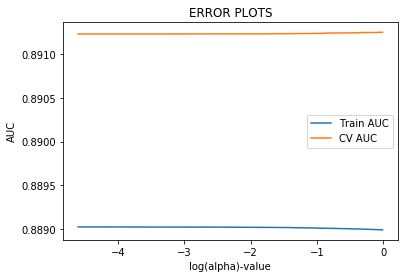

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from math import log


train_auc = []
cv_auc = []
alpha = np.arange(0.01, 1.0, 0.01)
logalpha = [log(y) for y in alpha]
for i in tqdm(alpha):
    nb = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    nb.fit(X_train_bow,y_train)

    y_train_pred =  nb.predict_log_proba(X_train_bow)[:,1]
    y_cv_pred = nb.predict_log_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha)-value")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()   

In [40]:
opt_auc = alpha[cv_auc.index(max(cv_auc))]
print(opt_auc)

0.99


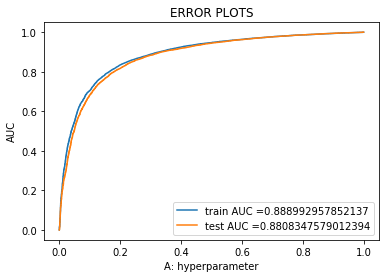

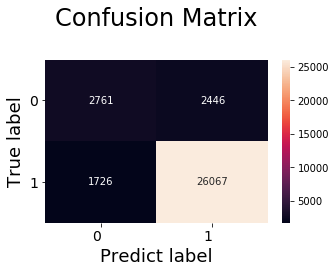

In [41]:
nb = MultinomialNB(alpha=opt_auc, class_prior=None, fit_prior=True)
nb.fit(X_train_bow,y_train)
   
    
train_fpr, train_tpr, thresholds = roc_curve(y_train, nb.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("A: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     

#Confusion Matrix
 
cm = confusion_matrix(y_train, nb.predict(X_train_bow))
cm = confusion_matrix(y_test, nb.predict(X_test_bow))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()   

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>


In [42]:
pos_sorted = nb.feature_log_prob_[1, :].argsort()
print(np.take(vectorizer.get_feature_names(), pos_sorted[-10:]))

['love' 'flavor' 'would' 'coffee' 'taste' 'one' 'great' 'good' 'like'
 'not']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [43]:
# Please write all the code with proper documentation
neg_sorted = nb.feature_log_prob_[0, :].argsort()
print(np.take(vectorizer.get_feature_names(), neg_sorted[-10:]))

['no' 'flavor' 'good' 'coffee' 'one' 'product' 'would' 'taste' 'like'
 'not']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 9/9 [00:00<00:00, 21.03it/s]


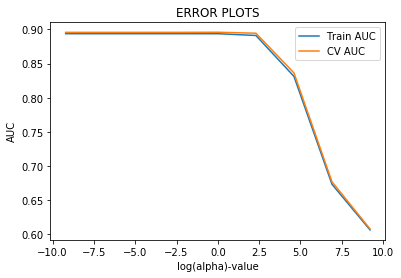

In [44]:
# Please write all the code with proper documentation
from math import log

train_auc = []
cv_auc = []
alpha = [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4]
logalpha = [log(y) for y in alpha]
for i in tqdm(alpha):
    nb = MultinomialNB(alpha=i, class_prior=None, fit_prior=True)
    nb.fit(X_train_tfidf, y_train)

    y_train_pred =  nb.predict_log_proba(X_train_tfidf)[:,1]
    y_cv_pred =  nb.predict_log_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(logalpha, train_auc, label='Train AUC')
plt.plot(logalpha, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("log(alpha)-value")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [48]:
best_auc = alpha[cv_auc.index(max(cv_auc))]
print(best_auc)

1


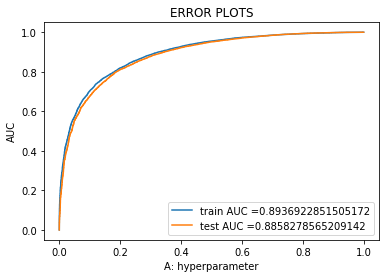

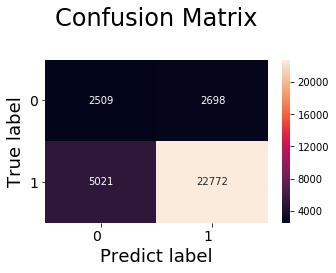

In [49]:
nb = MultinomialNB(alpha=best_auc, class_prior=None, fit_prior=True)
nb.fit(X_train_tfidf,y_train)
   
    
train_fpr, train_tpr, thresholds = roc_curve(y_train, nb.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, nb.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("A: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()
     

#Confusion Matrix
 
cm = confusion_matrix(y_train, nb.predict(X_train_bow))
cm = confusion_matrix(y_test, nb.predict(X_test_bow))
tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [50]:
pos_sorted = nb.feature_log_prob_[1, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), pos_sorted[-10:]))

['taste' 'one' 'product' 'tea' 'love' 'coffee' 'like' 'good' 'great' 'not']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [51]:
# Please write all the code with proper documentation

neg_sorted = nb.feature_log_prob_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), neg_sorted[-10:]))

['good' 'flavor' 'no' 'one' 'coffee' 'would' 'taste' 'product' 'like'
 'not']


# [6] Conclusions

In [53]:
from prettytable import PrettyTable

# Names of models
featurization = ['Bag of Words','TFIDF ','Bag of Words','TFIDF ']
 

alpha=[0.99,1,0.99,1]
 
numbering = [1,2,3,4]
# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("MODEL",featurization)
ptable.add_column("alpha",alpha)
 

print(ptable)


+-------+--------------+-------+
| S.NO. |    MODEL     | alpha |
+-------+--------------+-------+
|   1   | Bag of Words |  0.99 |
|   2   |    TFIDF     |   1   |
|   3   | Bag of Words |  0.99 |
|   4   |    TFIDF     |   1   |
+-------+--------------+-------+


#  Summary

### 1:What I observed firstly is that naive Bayes is faster than the KNN and gives faster and better result.

### 2: TFIDF and BOW gave more than 85% AUC value.

### 3: **Naive Bayes with Bow model has optimal value of alpha 0.99 where as Naive Bayes with TfIdf model has optimal value of alpha is 1. Vectorization of text optimal value may differ.** 